In [46]:
import sys
sys.path.append("../src")

In [47]:
from typing import List
from typing import Tuple

import tempfile
from pathlib import Path

import torch
from IPython.display import display
from IPython.display import Markdown

from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import textwrap

from health_multimodal.common.visualization import plot_phrase_grounding_similarity_map
from health_multimodal.text import get_bert_inference
from health_multimodal.text.utils import BertEncoderType
from health_multimodal.image import get_image_inference
from health_multimodal.image.utils import ImageModelType
from health_multimodal.vlp import ImageTextInferenceEngine

## Load BioViL model

# Load df

In [48]:
dir_name="../../../train"
df = pd.read_csv("../../../label_1024_split.csv")
print(len(df))
df_train = df.query('split == "train"')
df.head()

1448


,dicom_id,category_name,label_text,path,x,y,w,h,image_width,image_height,split
0,675d792f-a3521e48-5eec8573-1e81d644-e60c34f8,Pneumonia,Bibasilar opacities,files/p10/p10233088/s54276838/675d792f-a3521e4...,113,575,308,159,1024,1024,train
1,675d792f-a3521e48-5eec8573-1e81d644-e60c34f8,Pneumonia,Bibasilar opacities,files/p10/p10233088/s54276838/675d792f-a3521e4...,584,574,284,177,1024,1024,train
2,5318d353-daae9c3d-2ee8648e-32b65198-aeff801e,Pneumonia,Bilateral multifocal areas of consolidation,files/p10/p10123147/s50230934/5318d353-daae9c3...,608,425,304,267,1024,1024,val
3,5318d353-daae9c3d-2ee8648e-32b65198-aeff801e,Pneumonia,Bilateral multifocal areas of consolidation,files/p10/p10123147/s50230934/5318d353-daae9c3...,183,231,256,224,1024,1024,val
4,4decce85-c6ede74e-7a8bc81c-e81edee9-5ec17116,Pneumothorax,Large right-sided pneumothorax,files/p10/p10500801/s58577720/4decce85-c6ede74...,88,36,294,884,1024,1024,test


In [49]:
df["split"].value_counts()

split
train    948
val      321
test     179
Name: count, dtype: int64

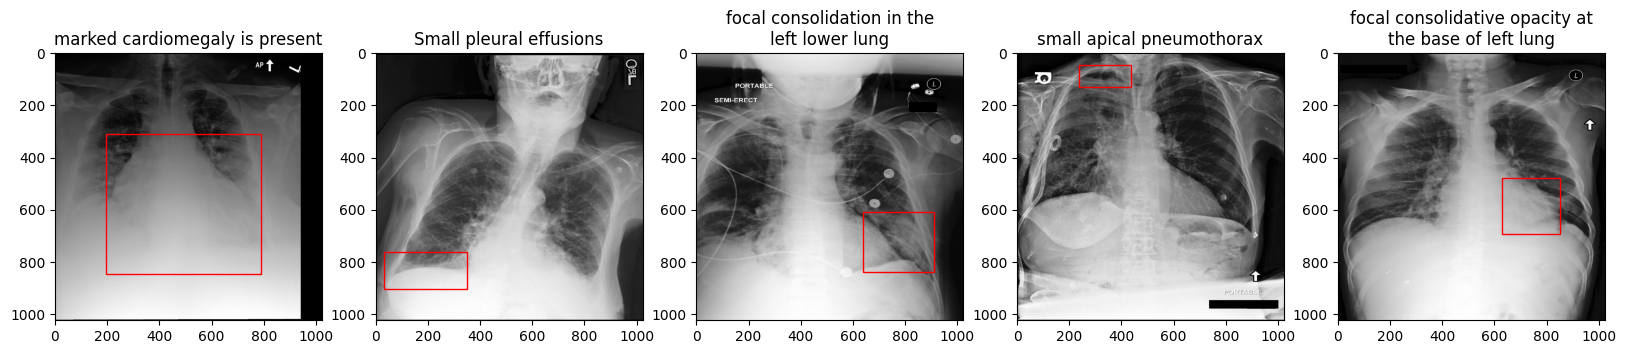

In [50]:
df_sample = df_train.sample(5, random_state=42)
fig = plt.figure(figsize=(20, 10))

for i, row in enumerate(df_sample.itertuples()):
    img_path = f"{dir_name}/{row.dicom_id }.jpg"
    img = Image.open(img_path)
    ax = fig.add_subplot(1, 5, i+1)
    ax.imshow(np.array(img), cmap='gray')
    rect = patches.Rectangle((row.x, row.y), row.w, row.h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    # ax.set_title(row.label_text)

    wrapper = textwrap.TextWrapper(width=30)  # it will wrap the text at 30 characters
    word_list = wrapper.wrap(text=row.label_text)
    label_new = '\n'.join(word_list)
    ax.set_title(label_new)


plt.show()


## Training

In [51]:
# def plot_phrase_grounding(image_path: Path, text_prompt: str, bboxes: List[TypeBox]) -> None:
#     similarity_map = BioVLP.get_similarity_map_from_raw_data(
#         image_path=image_path,
#         query_text=text_prompt,
#         interpolation="bilinear",
#     )

In [52]:
# class CustomDataset(Dataset):
#     def __init__(self, dataframe):
#         self.dataframe = dataframe

#     def __len__(self):
#         return len(self.dataframe)

#     def __getitem__(self, idx):
#         row = self.dataframe.iloc[idx]
#         image_path = f"{dir_name}/{row.dicom_id}.jpg"
#         # image = Image.open(image_path).convert('RGB')
#         # image = torch.tensor(np.array(image))
#         text_prompt = row.label_text
#         ground_truth_boxes = torch.tensor([row.x, row.y, row.w, row.h])

#         return image_path, text_prompt, ground_truth_boxes

# train_dataset = CustomDataset(df_train)
# train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [53]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader

# # train_loader = DataLoader(MyDataset(), batch_size=32, shuffle=True)

# import torch.nn as nn

# criterion = nn.MSELoss()
# optimizer = optim.Adam(BioViL.text_inference_engine.model.parameters(), lr=0.001)

# n_epochs = 10
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # model.to(device)

# for epoch in range(n_epochs):
#     # model.train()
    
#     for batch_idx, (image_path, text_prompt, ground_truth_boxes) in enumerate(train_loader):
#         image_path = Path(image_path[0])
#         text_prompt = text_prompt[0]
#         ground_truth_boxes = ground_truth_boxes[0]

#         # predicted_boxes = model(image_path, text_prompt)
#         # print(predicted_boxes.cpu().detach().numpy())
#         # print(ground_truth_boxes.cpu().detach().numpy())
#         # loss = criterion(predicted_boxes, ground_truth_boxes.view(1, -1).float())
#         # print(ground_truth_boxes)
        
#         similarity_map = BioViL.get_similarity_map_from_raw_data(
#             image_path=image_path,
#             query_text=text_prompt,
#             interpolation="bilinear",
#         ).clip(0)
#         assert similarity_map.shape[0] == 1024
#         assert similarity_map.shape[1] == 1024


#         row_x, row_y, row_w, row_h = (ground_truth_boxes).detach().int()

#         # Calculate the sum within the box
#         sum_val = torch.sum(similarity_map[row_x:row_x+row_w, row_y:row_y+row_h])
#         loss = -sum_val / torch.sum(similarity_map)
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         if batch_idx % 1 == 0:
#             print(f"Epoch {epoch+1}/{n_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item()}")
    



In [54]:
# total_trainable_params = sum(p.numel() for p in BioViL.text_inference_engine.model.parameters() if p.requires_grad)
# total_trainable_params

109629498

In [55]:
# total_params = sum(p.numel() for p in BioViL.text_inference_engine.model.parameters())
# total_params

109629498

# batch_size>1

In [56]:
import torch.nn.functional as F
from scipy import ndimage
from health_multimodal.image.model.model import BaseImageModel
from health_multimodal.text import TextInferenceEngine
from health_multimodal.image import ImageInferenceEngine
from health_multimodal.image.data.transforms import infer_resize_params
from typing import Callable, List, Optional, Union
from math import ceil, floor
from health_multimodal.image.data.io import load_image



class ImageTextModel:

    def __init__(
        self, image_inference_engine: ImageInferenceEngine, text_inference_engine: TextInferenceEngine, width, height
    ) -> None:
        self.image_model = image_inference_engine.model
        self.text_inference_engine = text_inference_engine
        self.width = width
        self.height = height
        self.resize_size, self.crop_size = image_inference_engine.resize_size, image_inference_engine.crop_size
        self.transform = image_inference_engine.transform


    def get_similarity_maps_from_raw_data(
        self, images: torch.Tensor, query_text: List[str], interpolation: str = "nearest"
    ) -> torch.Tensor:
        """Return a heatmap of the similarities between each patch embedding from the image and the text embedding.

        :param image_path: Path to the input chest X-ray, either a DICOM or JPEG file.
        :param query_text: Input radiology text phrase.
        :param interpolation: Interpolation method to upsample the heatmap so it matches the input image size.
            See :func:`torch.nn.functional.interpolate` for more details.
        :return: A heatmap of the similarities between each patch embedding from the image and the text embedding,
            with the same shape as the input image.
        """
        # assert not self.image_inference_engine.model.training
        # assert not self.text_inference_engine.model.training
        # assert isinstance(query_text, str)

        # TODO: Add checks in here regarding the text query, etc.
        # image_embedding, (width, height) = self.image_inference_engine.get_projected_patch_embeddings(image_paths)
        text_embedding = self.text_inference_engine.get_embeddings_from_prompt(query_text)
        image_embedding = self.image_model.get_patchwise_projected_embeddings(images, normalize=False)

        sim = self._get_similarity_maps_from_embeddings(image_embedding, text_embedding)

        resized_sim_maps = self.convert_multiple_similarity_to_image_size(
            sim,
            width=self.width,
            height=self.height,
            resize_size=self.resize_size,
            crop_size=self.crop_size,
            val_img_transform=self.transform,
            interpolation=interpolation,
        )
        return resized_sim_maps

    @staticmethod
    def _get_similarity_maps_from_embeddings(
        projected_patch_embeddings: torch.Tensor, projected_text_embeddings: torch.Tensor, sigma: float = 1.5
    ) -> torch.Tensor:
        """Get smoothed similarity map for a given image patch embeddings and text embeddings.

        :param projected_patch_embeddings: [batch_size, n_patches_h, n_patches_w, feature_size]
        :param projected_text_embeddings: [batch_size, feature_size]
        :return: similarity_map: similarity map of shape [batch_size, n_patches_h, n_patches_w]
        """
        batch_size, n_patches_h, n_patches_w, feature_size = projected_patch_embeddings.shape
        assert feature_size == projected_text_embeddings.shape[1]
        assert projected_text_embeddings.shape[0] == batch_size
        assert projected_text_embeddings.dim() == 2
        # patch_wise_similarity = projected_patch_embeddings.view(batch_size, -1, feature_size) @ projected_text_embeddings.t().unsqueeze(0) #TODO: check
        # print(projected_patch_embeddings.shape)
        # print(projected_text_embeddings.shape)
        # similarity_map = patch_wise_similarity.reshape(batch_size, n_patches_h, n_patches_w)
        # return similarity_map
        similarity_map = torch.einsum("bhwc,bc->bhw", projected_patch_embeddings, projected_text_embeddings)
        return similarity_map

    @staticmethod
    def convert_multiple_similarity_to_image_size(
        similarity_map: torch.Tensor,
        width: int,
        height: int,
        resize_size: Optional[int],
        crop_size: Optional[int],
        val_img_transform: Optional[Callable] = None,
        interpolation: str = "nearest",
    ) -> torch.tensor:
        """
        Convert similarity map from raw patch grid to original image size,
        taking into account whether the image has been resized and/or cropped prior to entering the network.
        """
        batch_size, n_patches_h, n_patches_w = similarity_map.shape[0], similarity_map.shape[1], similarity_map.shape[2]
        target_shape = batch_size, 1, n_patches_h, n_patches_w
        smallest_dimension = min(height, width)

        # TODO:
        # verify_resize_params(val_img_transforms, resize_size, crop_size)

        reshaped_similarity = similarity_map.reshape(target_shape)
        align_corners_modes = "linear", "bilinear", "bicubic", "trilinear"
        align_corners = False if interpolation in align_corners_modes else None

        if crop_size is not None:
            if resize_size is not None:
                cropped_size_orig_space = int(crop_size * smallest_dimension / resize_size)
                target_size = cropped_size_orig_space, cropped_size_orig_space
            else:
                target_size = crop_size, crop_size
            # return reshaped_similarity[0, 0]
            similarity_map = F.interpolate(
                reshaped_similarity,
                size=target_size,
                mode=interpolation,
                align_corners=align_corners,
            )
            margin_w, margin_h = (width - target_size[0]), (height - target_size[1])
            margins_for_pad = (floor(margin_w / 2), ceil(margin_w / 2), floor(margin_h / 2), ceil(margin_h / 2))

            # Pad with zeros for differentiability instead of NaNs
            similarity_map = F.pad(similarity_map[:, 0, :], margins_for_pad, value=0.0)
        else:
            similarity_map = F.interpolate(
                reshaped_similarity,
                size=(height, width),
                mode=interpolation,
                align_corners=align_corners,
            )[:, 0, :]
        return similarity_map#.numpy()


    def to(self, device: torch.device) -> None:
        """Move models to the specified device."""
        self.image_inference_engine.to(device)
        self.text_inference_engine.to(device)


In [57]:

# Load BioViL Model
text_inference = get_bert_inference(BertEncoderType.BIOVIL_T_BERT)
image_inference = get_image_inference(ImageModelType.BIOVIL_T)

BioViL = ImageTextModel(
    image_inference,
    text_inference,
    1024, 1024
)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'CXRBertTokenizer'.
You are using a model of type bert to instantiate a model of type cxr-bert. This is not supported for all configurations of models and can yield errors.


Using downloaded and verified file: /tmp/biovil_t_image_model_proj_size_128.pt


In [58]:
text_inference.get_embeddings_from_prompt(["test"]).shape

torch.Size([1, 128])

In [59]:
text_inference.get_embeddings_from_prompt(["test hello"]).shape

torch.Size([1, 128])

In [60]:
text_inference.get_embeddings_from_prompt(["test", "hello"]).shape

torch.Size([2, 128])

In [61]:
text_inference.get_embeddings_from_prompt(["test", "hello"]).mean(dim=0).shape

torch.Size([128])

## Test

In [62]:
width, height = df_sample.iloc[0]["image_width"], df_sample.iloc[0]["image_height"]
model = ImageTextModel(image_inference_engine=image_inference, text_inference_engine=text_inference, width=width, height=height)

In [63]:

for i, row in enumerate(df_sample.itertuples()):
    # display(row)
    img_path = Path(f"{dir_name}/{row.dicom_id }.jpg")
    image, _ = image_inference.load_and_transform_input_image(img_path, image_inference.transform)
    print(image.shape)

torch.Size([1, 3, 448, 448])
torch.Size([1, 3, 448, 448])
torch.Size([1, 3, 448, 448])
torch.Size([1, 3, 448, 448])
torch.Size([1, 3, 448, 448])


In [64]:
images = torch.concat([image_inference.load_and_transform_input_image(Path(f"{dir_name}/{dicom_id }.jpg"), image_inference.transform)[0] for dicom_id in df_sample["dicom_id"]])
images.shape

torch.Size([5, 3, 448, 448])

In [65]:
model.image_model.get_patchwise_projected_embeddings(images, normalize=False).shape

torch.Size([5, 14, 14, 128])

In [66]:
texts = df_sample["label_text"].tolist()
texts

['marked cardiomegaly is present',
 'Small pleural effusions',
 'focal consolidation in the left lower lung',
 'small apical pneumothorax',
 'focal consolidative opacity at the base of left lung']

In [67]:
similarity_maps = model.get_similarity_maps_from_raw_data(images, texts)

In [68]:
similarity_maps.shape

torch.Size([5, 1024, 1024])

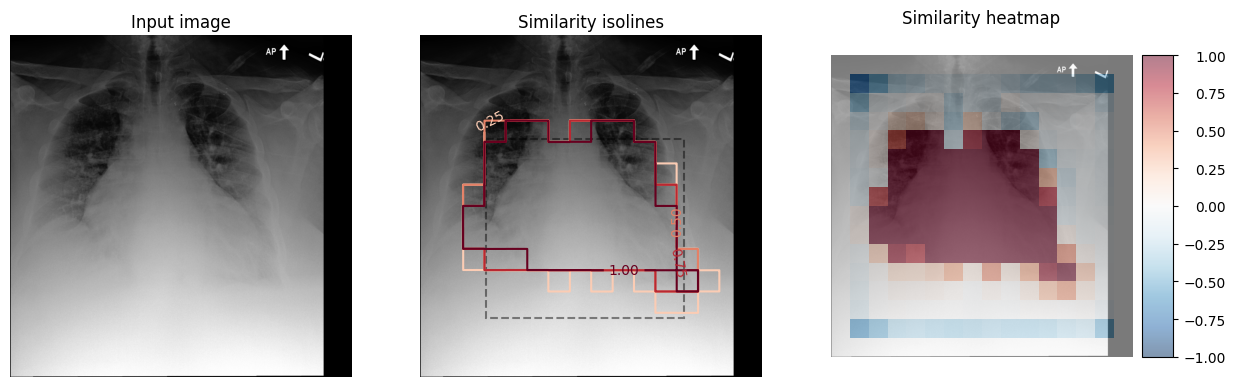

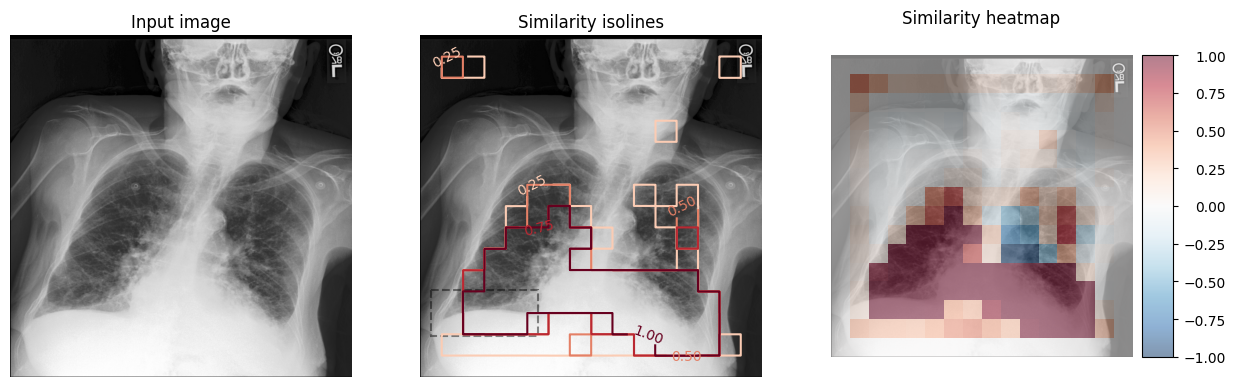

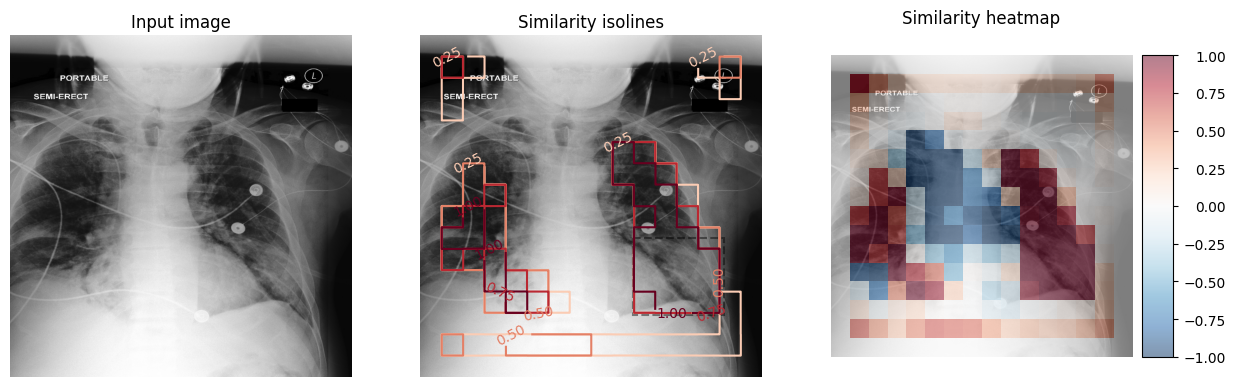

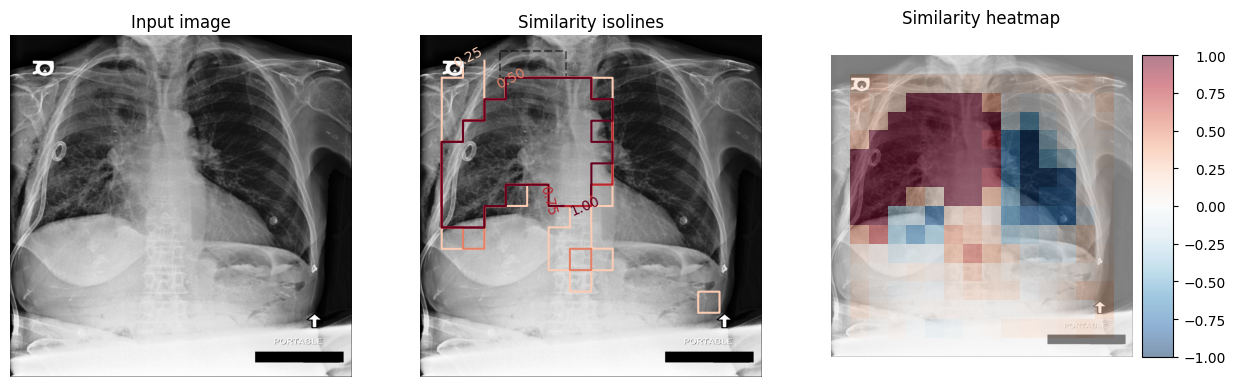

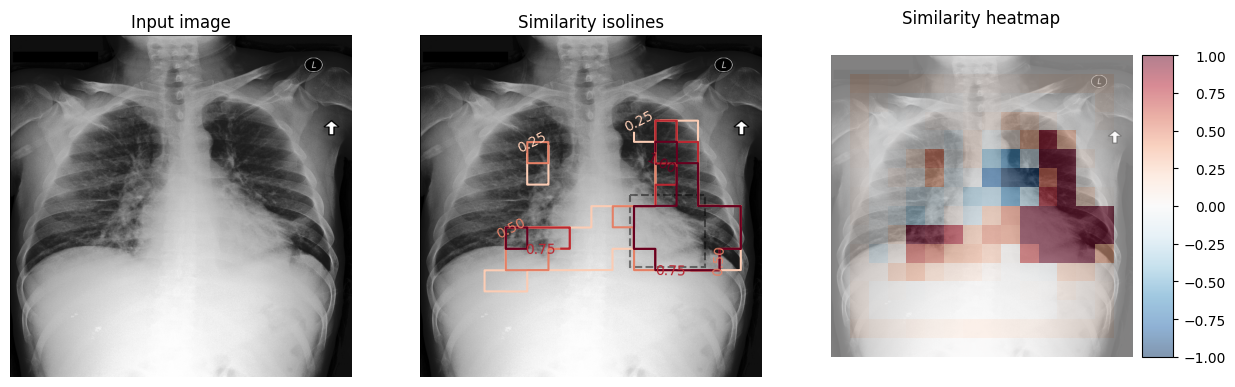

In [69]:

with torch.no_grad():
    for i, row in enumerate(df_sample.itertuples()):
        similarity_map = similarity_maps[i]
        img_path = Path(f"{dir_name}/{row.dicom_id }.jpg")
        box = row.x, row.y, row.w, row.h

        plot_phrase_grounding_similarity_map(
            image_path=img_path,
            similarity_map=similarity_map,
            bboxes=[box]
        )

# DataLoader

In [70]:
class CustomDataset2(Dataset):
    def __init__(self, dataframe, device, transform):
        self.dataframe = dataframe
        self.device = device
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = Path(f"{dir_name}/{row.dicom_id}.jpg")
        # image = Image.open(image_path).convert('RGB')
        # image = torch.tensor(np.array(image))
        text_prompt = row.label_text
        ground_truth_boxes = torch.tensor([row.x, row.y, row.w, row.h])
        image = load_image(image_path)
        transformed_image = self.transform(image)

        return transformed_image, text_prompt, ground_truth_boxes

batch_size = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset = CustomDataset2(df_train, device, image_inference.transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# train_loader = DataLoader(MyDataset(), batch_size=32, shuffle=True)

import torch.nn as nn

criterion = nn.MSELoss()
optimizer = optim.Adam(BioViL.text_inference_engine.model.parameters(), lr=0.001)

n_epochs = 10
# model.to(device)

for epoch in range(n_epochs):
    # model.train()
    
    for batch_idx, (images, text_prompt, ground_truth_boxes) in enumerate(train_loader):


        # predicted_boxes = model(image_path, text_prompt)
        # print(predicted_boxes.cpu().detach().numpy())
        # print(ground_truth_boxes.cpu().detach().numpy())
        # loss = criterion(predicted_boxes, ground_truth_boxes.view(1, -1).float())
        # print(ground_truth_boxes)
        loss = 0
        
        similarity_map = model.get_similarity_maps_from_raw_data(
            images=images,
            query_text=text_prompt,
            interpolation="bilinear",
        ).clip(0)
        assert similarity_map.shape[1] == 1024
        assert similarity_map.shape[2] == 1024

    
        for i in range(batch_size):
            row_x, row_y, row_w, row_h = (ground_truth_boxes[i]).detach().int()

            # Calculate the sum within the box
            sum_val = torch.sum(similarity_map[i][row_x:row_x+row_w, row_y:row_y+row_h])
            loss -= sum_val / torch.sum(similarity_map[i]) / batch_size
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_idx % 1 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item()}")
    



Epoch 1/10, Batch 0/190, Loss: -0.20635993778705597
Epoch 1/10, Batch 1/190, Loss: -0.18137779831886292
Epoch 1/10, Batch 2/190, Loss: -0.247219517827034


KeyboardInterrupt: 